In [1]:
from fastkaggle import *

In [2]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not iskaggle and not cred_path.exists():
    raise Exception('Need to download kaggle credentials')

In [3]:
comp = 'tpu-getting-started'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
classes = ["pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily","moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower","giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth","corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation","garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower","great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia","bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy","primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia","pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush","californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea","water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium","frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen ","watercress","canna lily","hippeastrum ","bee balm","pink quill","foxglove","bougainvillea","camellia","mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip","wild rose"]

In [4]:
path

Path('tpu-getting-started')

In [21]:
import timm
import functools
import itertools
from fastai.vision.all import *

path.ls()

(#5) [Path('tpu-getting-started/tfrecords-jpeg-512x512'),Path('tpu-getting-started/tfrecords-jpeg-224x224'),Path('tpu-getting-started/sample_submission.csv'),Path('tpu-getting-started/tfrecords-jpeg-331x331'),Path('tpu-getting-started/tfrecords-jpeg-192x192')]

In [22]:
data_paths = list(filter(lambda x: str(x) != "tpu-getting-started/sample_submission.csv", path.ls()))
data_paths = [Path('tpu-getting-started/tfrecords-jpeg-224x224')]
data_paths = functools.reduce(lambda acc, path: list(itertools.chain(acc, (path/'train').ls(), (path/'val').ls())), data_paths, [])

In [32]:
import tensorflow as tf

# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file_in_python
def load_tfrecs(data_paths, schema={'class': 'int64_list', 'image': 'bytes_list', 'id': 'bytes_list'}):
    data = []
    raw_dataset = tf.data.TFRecordDataset(data_paths)
    
    for record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(record.numpy())
        datum = [getattr(example.features.feature[name], datatype).value[0] for name, datatype in schema.items()]
        data.append(datum)
        
    return data

data = load_tfrecs(data_paths)
    
len(data)

16465

(224, 224)


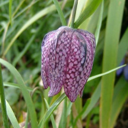

In [27]:
img = PILImage.create(data[0][1])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o[1]).size
sizes = parallel(f, data, n_workers=8)
pd.Series(sizes).value_counts()

(224, 224)    16465
Name: count, dtype: int64

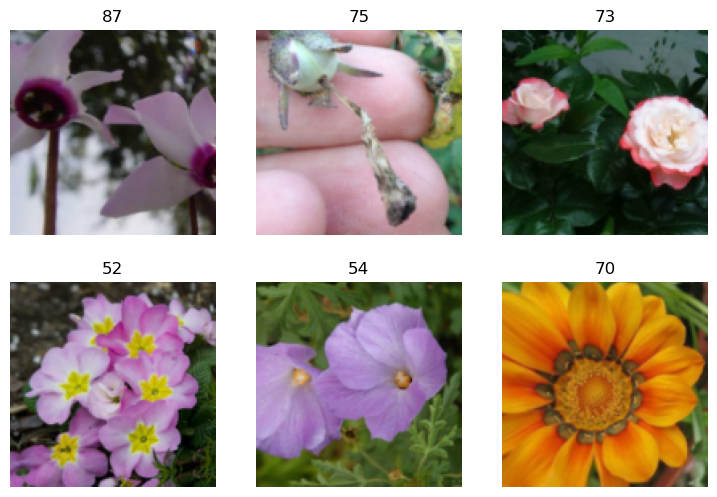

In [36]:
def get_items(data, *args, **kwargs): return data

get_x = lambda entry: PILImage.create(io.BytesIO(entry[1]))
get_y = lambda entry: entry[0]

block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=IndexSplitter(range(12753, len(data))),
                  item_tfms=[Resize(192, method='squish')],
                  batch_tfms=[*aug_transforms(size=128, min_scale=0.75)])

dls = block.dataloaders(data, bs=64)
dls.show_batch(max_n=6)

In [11]:
from torcheval.metrics.functional import multiclass_f1_score

learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()

/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


SuggestedLRs(valley=0.0012022644514217973, slide=2.75422871709452e-06)

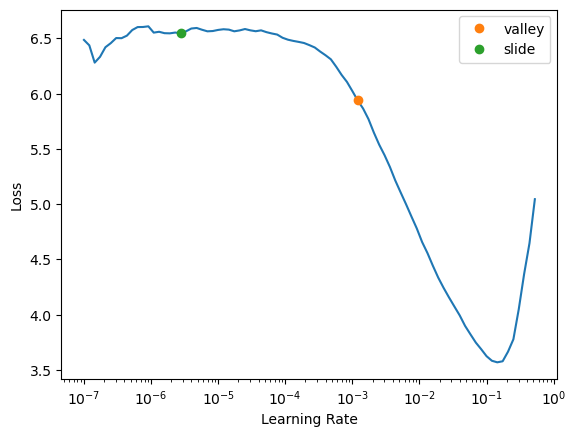

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(5, 0.001)

In [13]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

,id,label
0,b48c962e0,0
1,a13d3dfa4,0
2,94269c190,0
3,bcb18c6e4,0
4,d15a4d94c,0
...,...,...
7377,3744d58d1,0
7378,075602d66,0
7379,b4d954bdc,0
7380,f84335116,0


In [17]:
# torch.save(learn.model.state_dict(), '01.pth')
# from google.colab import files
# files.download('model_state_dict.pth')
# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth'))

# learn = vision_learner(dls, 'convnext_small_in22k', metrics=multiclass_f1_score, path='.').to_fp16()
# learn.model.load_state_dict(torch.load('01.pth', map_location=torch.device('cpu')))

/nix/store/i3j0gl8kmy0xly00r8qzjgkfywgbhmz6-python3-3.11.9-env/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


<All keys matched successfully>

In [37]:
test_paths = [Path('tpu-getting-started/tfrecords-jpeg-224x224/test').ls()]
test_data = load_tfrecs(test_paths, {'id': 'bytes_list', 'image': 'bytes_list'})
len(test_data)
test_dataloader = dls.test_dl(test_data)

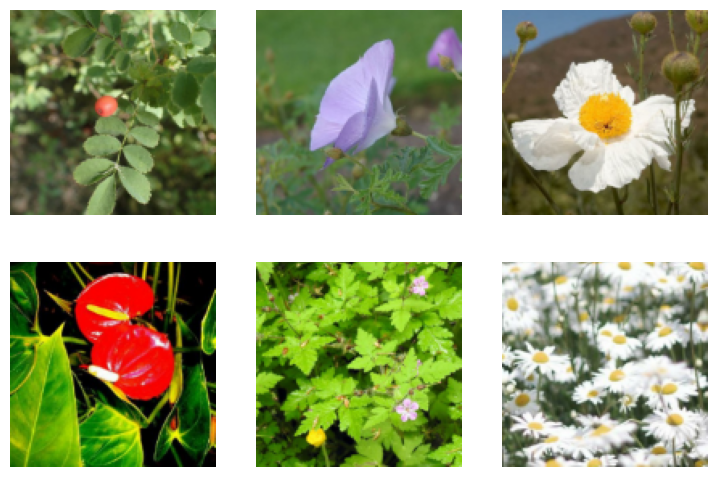

In [38]:
test_dataloader.show_batch(max_n=6)